# Importing Libraries

In [1]:
import onnxruntime
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Necessary functions

In [2]:
def show(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# Converts the frame to matplotlib format 
    fig, ax = plt.subplots(figsize=(20, 12)) # larger fig size for better visuals
    plt.imshow(frame) # displaying the frame

In [3]:
def preprocessor(frame):
    x = cv2.resize(frame, (640, 640))
    image_data = np.array(x).astype(np.float32) / 255.0  # Normalize to [0, 1] range
    image_data = np.transpose(image_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    image_data = np.expand_dims(image_data, axis=0)  # Add batch dimension
    return image_data

# Class for Inference

In [4]:
class Inference:
    def __init__(self, model, path):
        self.session = onnxruntime.InferenceSession(model, providers=["CPUExecutionProvider"])
        model_inputs = self.session.get_inputs()
        input_shape = model_inputs[0].shape
        self.path = path
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]
        self.classes = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train',
                        7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant',
                        11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog',
                        17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant',
                        21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag',
                        27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis',
                        31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove',
                        36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
                        41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple',
                        48: 'sandwich', 49: 'orange', 50: 'broccoli',
                        51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch',
                        58: 'potted plant', 59: 'bed', 60: 'dining table',
                        61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',
                        67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster',
                        71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors',
                        77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

    def detector(self, image_data):
        ort = onnxruntime.OrtValue.ortvalue_from_numpy(image_data)
        return self.session.run(["output0"], {"images": ort})

    def draw_detections(self, img, box, score, class_id):
        x1, y1, w, h = box
        color = (0, 255, 0)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)
        label = f'{self.classes[class_id]}: {score:.2f}'
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                      cv2.FILLED)
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        return img

    def postprocessor(self, results, frame, confidence, iou):
        img_height, img_width = frame.shape[:2]
        outputs = np.transpose(np.squeeze(results[0]))
        rows = outputs.shape[0]
        boxes = []
        scores = []
        class_ids = []
        x_factor = img_width / self.input_width  # img_width = 640
        y_factor = img_height / self.input_height  # img_width = 640
        for i in range(rows):
            classes_scores = outputs[i][4:]
            max_score = np.amax(classes_scores)
            if max_score >= confidence:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)
                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]
                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, confidence, iou)
        for i in indices:
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            frame = self.draw_detections(frame, box, score, class_id)
        return frame

    def pipeline(self):
        frame = cv2.imread(self.path)
        frame = self.postprocessor(self.detector(preprocessor(frame)), frame, 0.35, 0.35)
        return frame

# Comparision

In [5]:
static_quantized = 'models/static_quantized.onnx'
dynamic_quantized = 'models/dynamic_quantized.onnx'
yolov8n = 'models/yolov8n.onnx'
path = 'calibration_data/frame_0001.jpg'

True

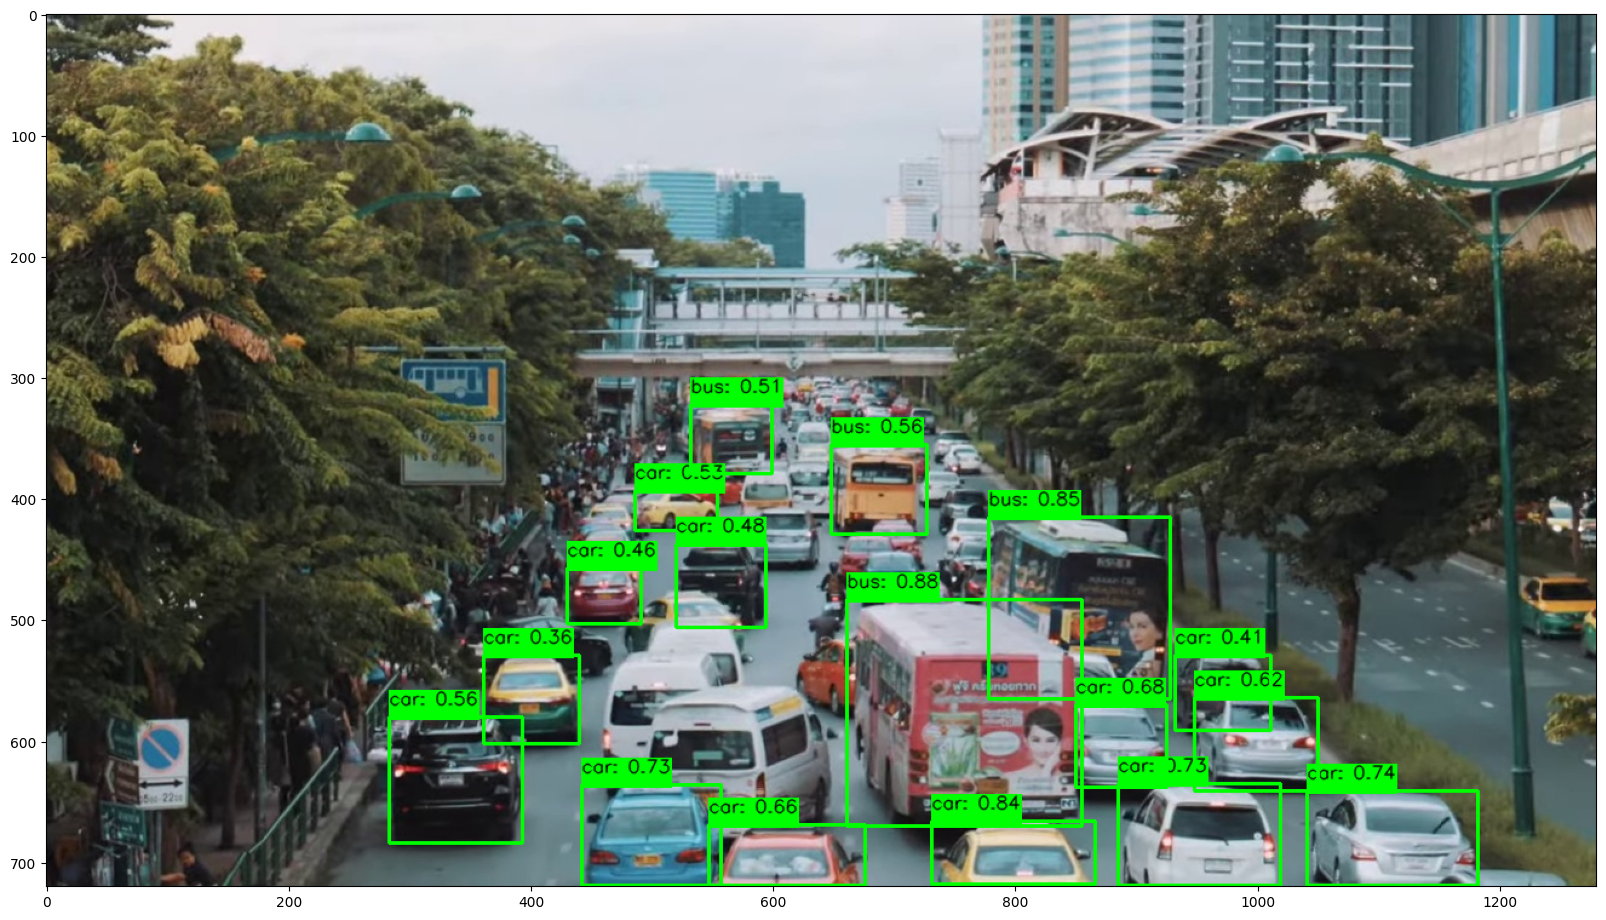

In [6]:
# Using unquantized model
x = Inference(yolov8n, path)
y = x.pipeline()
show(y)
cv2.imwrite('results/yolov8n.jpg', y) # saving the image

True

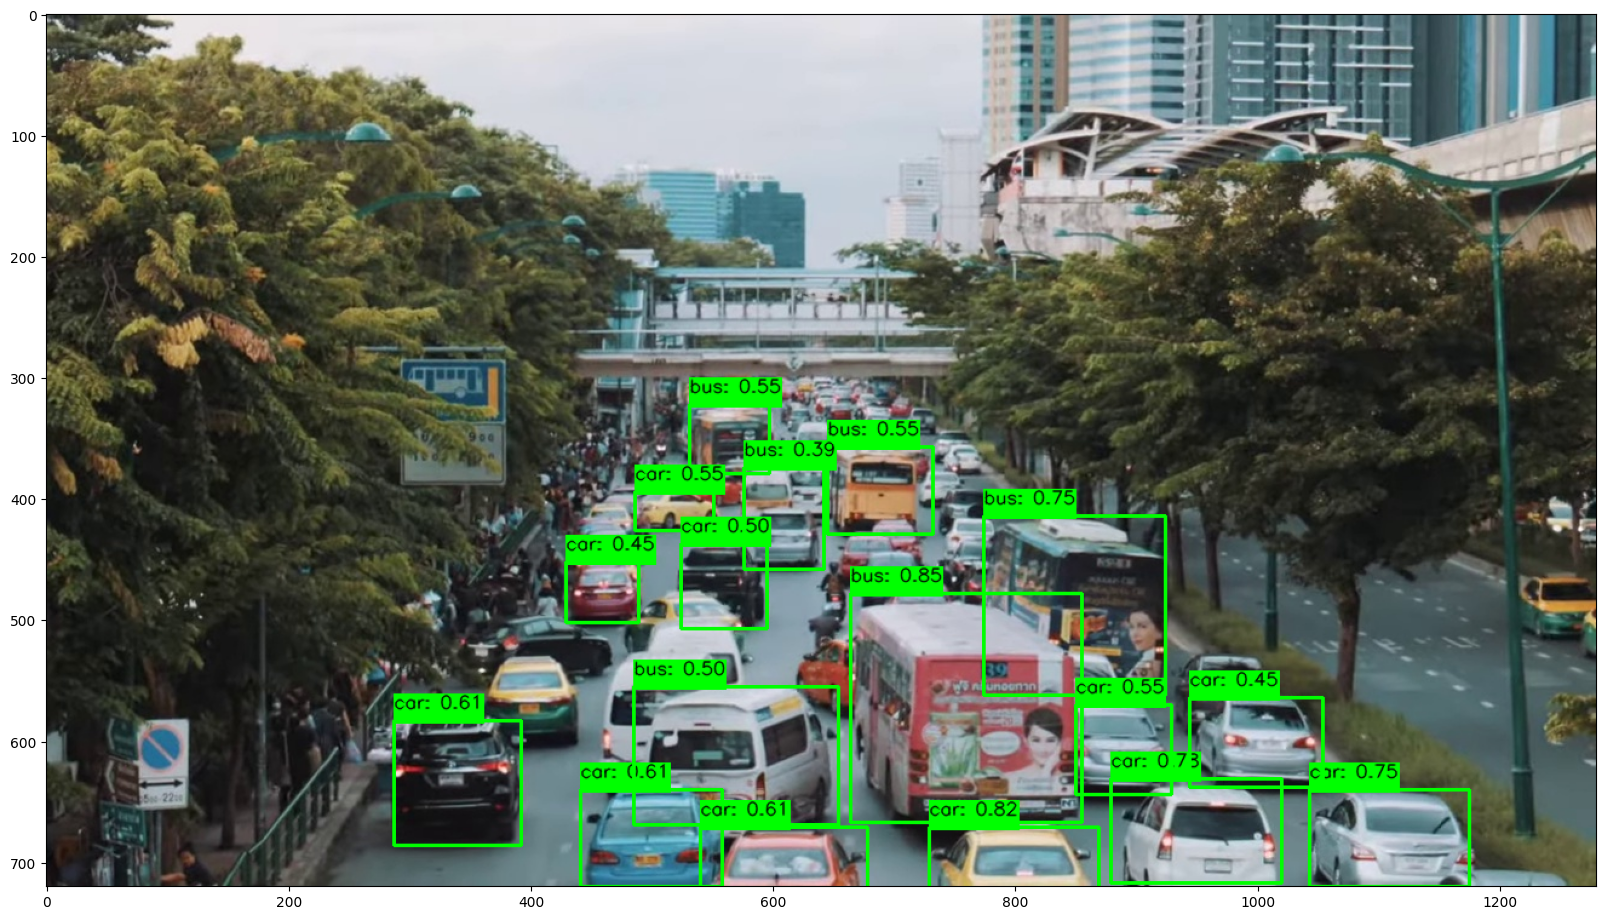

In [7]:
# Using static_quantized model
x = Inference(static_quantized, path)
y = x.pipeline()
show(y)
cv2.imwrite('results/static_quantized.jpg', y) # saving the image

True

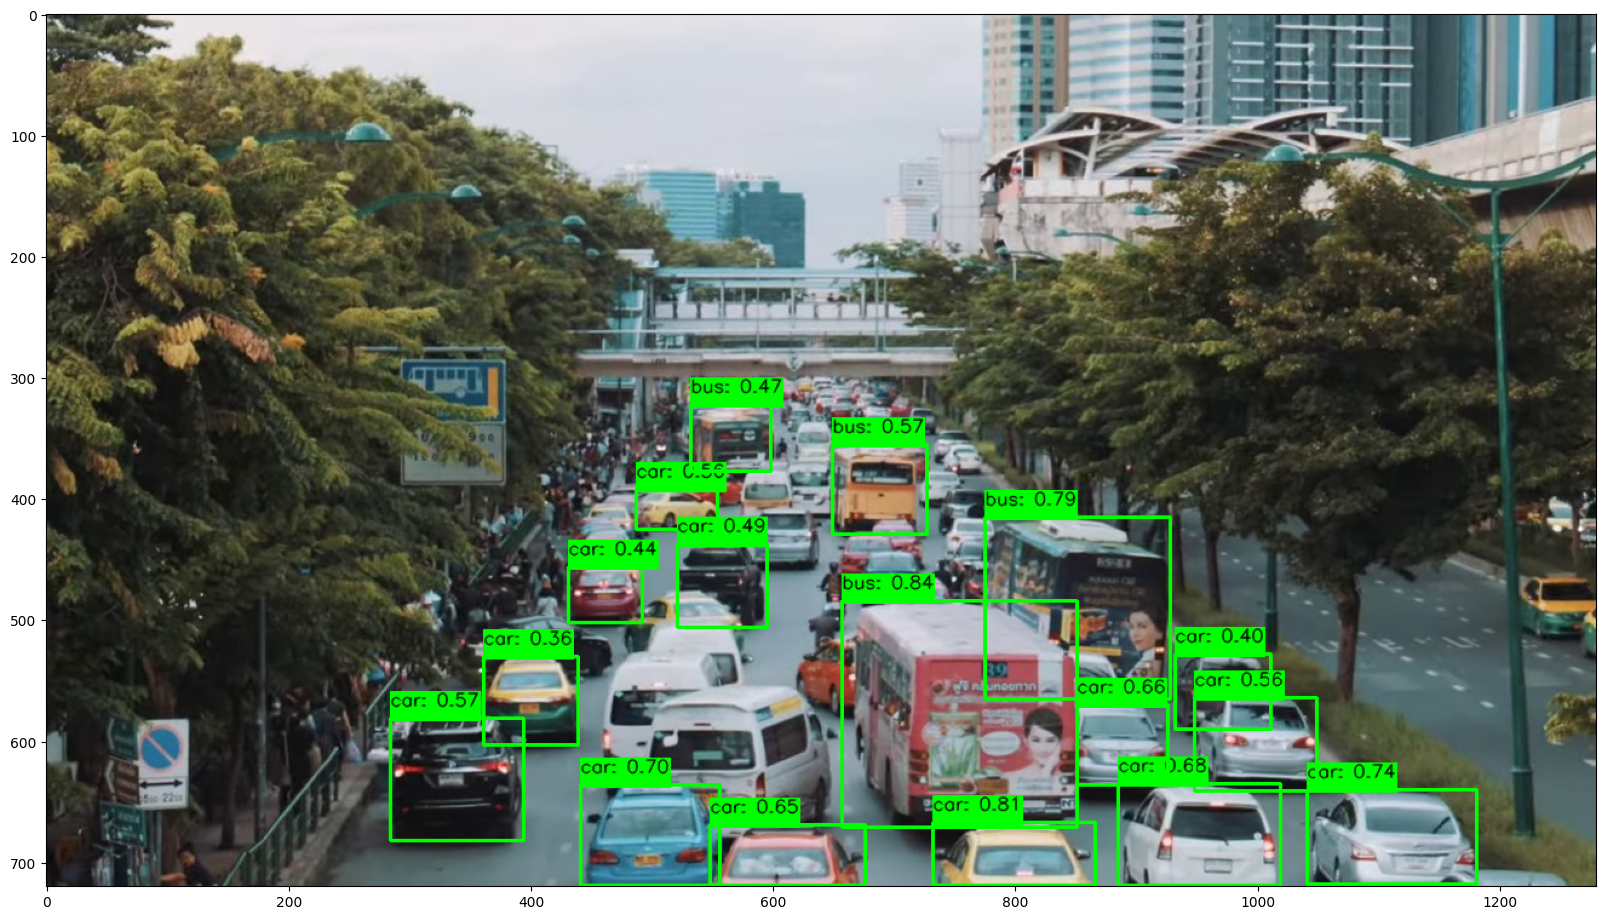

In [8]:
# Using dynamic_quantized model
x = Inference(dynamic_quantized, path)
y = x.pipeline()
show(y)
cv2.imwrite('results/dynamic_quantized.jpg', y) # saving the image